In [1]:
import numpy as np
import sys, os
sys.path.append('..')
import matplotlib.pyplot as plt

In [2]:
### RNN 계층 구현
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = [x, h_prev, h_next]
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

In [97]:
### TimeRNN 계층 구현
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h = None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh
        
        return dxs

In [4]:
xs = np.random.randn(2,3,5)
N, T, D = xs.shape

Wx = np.random.randn(5, 4)
Wh = np.random.randn(4, 4)
b = np.random.randn(2, 4)
D, H = Wx.shape

hs = np.empty((N, T, H), dtype='f')
params = [Wx, Wh, b]
h = np.empty((N, H), dtype='f')

In [5]:
layers = []

for t in range(T):
    layer = RNN(*params)
    h = layer.forward(xs[:,t,:], h)
    hs[:,t,:] = h
    layers.append(layer)
hs
h

array([[ 0.66490644, -0.55840267, -0.83988031,  0.39517619],
       [ 0.99162458, -0.92132372, -0.98987293,  0.99970973]])

In [6]:
hs

array([[[-1.        , -1.        , -1.        ,  1.        ],
        [-0.8856359 ,  0.9997306 ,  0.85615975, -0.98882174],
        [ 0.66490644, -0.55840266, -0.8398803 ,  0.3951762 ]],

       [[ 1.        , -1.        ,  1.        , -1.        ],
        [ 0.9999933 , -0.9897862 , -0.9420544 ,  0.99607164],
        [ 0.9916246 , -0.9213237 , -0.98987293,  0.9997097 ]]],
      dtype=float32)

In [7]:
for t in range(3):
    print(f't={t}: {xs[:,t,:]}')

t=0: [[-0.980594   -1.35995936  0.15123834  1.20061991 -0.8257638 ]
 [-0.06607025  1.18199682  0.18432254  0.37701493  1.4033216 ]]
t=1: [[-0.58377788 -0.14037485 -1.77050984  0.279275   -0.440828  ]
 [-0.50114772  0.22695098  1.40972774  1.59996187  0.92768662]]
t=2: [[-0.63393649  0.48414264  0.97589821  0.1613117  -0.27203646]
 [-0.14367692  1.10831132  1.50480132 -0.45087874  0.21192525]]


In [8]:
layers.reverse()

In [9]:
dhs = np.random.randn(N, T, H)
dxs = np.empty((N, T, D))
dxs

array([[[0.00000000e+000, 9.88131292e-322, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000],
        [5.02034658e+175, 6.74814565e-067, 3.70077714e-033,
         2.73961490e-057, 1.18996261e-075],
        [7.48678488e-144, 3.59751658e+252, 3.96046095e+246,
         1.04918621e-153, 7.69165785e+218]],

       [[3.22068560e+257, 1.04918335e-153, 9.08366793e+223,
         6.74814565e-067, 3.70077714e-033],
        [2.73961490e-057, 1.18996261e-075, 1.04914908e-153,
         1.94918966e-153, 1.68891033e-052],
        [6.36601159e-062, 1.69053530e-052, 2.59027896e-144,
         7.79952704e-143, 5.81186265e+294]]])

In [10]:
dh = 0
grads = [0, 0, 0]

layer = layers[0]
dx, dh_prev = layer.backward(dhs[:, 2, :] + dh)
dx, dh_prev
dxs[:, 2, :] = dx
for i, grad in enumerate(layer.grads):
    grads[i] += grad

In [11]:
layer.grads[0].shape

(5, 4)

In [12]:
for i, grad in enumerate(layer.grads):
    print(i, grad)

0 [[ 0.19728678 -0.61887071  0.04514434 -0.23862808]
 [-0.16335305  0.51147772 -0.04477455  0.18216294]
 [-0.32001223  1.00263332 -0.08273312  0.36724825]
 [-0.04401048  0.13851863 -0.00646096  0.06076011]
 [ 0.08118535 -0.25493021  0.01655129 -0.10242243]]
1 [[ 0.26036708 -0.8178853   0.05068671 -0.33346885]
 [-0.29567559  0.92865969 -0.0586503   0.37641792]
 [-0.2520146   0.79162311 -0.04925399  0.32236822]
 [ 0.29223222 -0.91786176  0.05783413 -0.37231187]]
2 [[-0.32103184  1.00631508 -0.07918761  0.37636125]
 [-0.32103184  1.00631508 -0.07918761  0.37636125]]


In [13]:
from common.layers import *

In [98]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
            
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None

In [14]:
W = np.random.randn(2,3)
grads = [np.zeros_like(W)]
grads[0]

array([[0., 0., 0.],
       [0., 0., 0.]])

In [15]:
grads

[array([[0., 0., 0.],
        [0., 0., 0.]])]

In [93]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

In [94]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params = []
        self.grads = []
        self.cache = None
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:
            ts = ts.argmax(axis=2)
            
        mask = (ts != self.ignore_label)
        
        xs = xs.reshape(N*T, V)
        ts = ts.reshape(N*T)
        mask = mask.reshape(N*T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N*T), ts])
        ls *= mask
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        
        dx = ys
        dx[np.arange(N*T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]
        
        dx = dx.reshape((N,T,V))
        
        return dx

In [48]:
ignore_label = -1
xs = np.random.randn(2,3)
ts = np.array([[0,0,1], [0,0,0]])

In [49]:
ts = ts.argmax(axis=1)
ts

array([2, 0])

In [50]:
mask = (ts != ignore_label)

In [36]:
ys = softmax(xs)

In [37]:
[np.arange(2), ts]

[array([0, 1]), array([2, 0])]

In [42]:
ls = np.log(ys[np.arange(2), ts])
ls

array([-2.26618235, -0.18814754])

In [46]:
ls *= mask
loss = -np.sum(ls)
loss

2.454329894576318

In [47]:
loss /= mask.sum()

In [99]:
### RNNLM 구현
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        embed_W = (np.random.randn(V,D) / 100).astype('f')
        rnn_Wx = (np.random.randn(D,H) / np.sqrt(D)).astype('f')
        rnn_Wh = (np.random.randn(H,H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (np.random.randn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params = []
        self.grads = []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)      
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)   
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [84]:
from common.optimizer import SGD
from dataset import ptb

In [118]:
### RNNLM의 학습 코드
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기 (전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print(f'말뭉치 크기: {corpus_size}, 어휘 수: {vocab_size}')

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ppl = np.exp(total_loss / loss_count)
    print(f'| 에폭 {epoch+1} | 퍼플렉서티 {ppl}')
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 386.63573886045356
| 에폭 2 | 퍼플렉서티 254.45184838343573
| 에폭 3 | 퍼플렉서티 223.84327488732077
| 에폭 4 | 퍼플렉서티 213.3841093771167
| 에폭 5 | 퍼플렉서티 204.6786788390891
| 에폭 6 | 퍼플렉서티 202.24649472226182
| 에폭 7 | 퍼플렉서티 197.73296674073498
| 에폭 8 | 퍼플렉서티 196.79936410083113
| 에폭 9 | 퍼플렉서티 191.02847513545132
| 에폭 10 | 퍼플렉서티 192.7155327117058
| 에폭 11 | 퍼플렉서티 187.87836486586866
| 에폭 12 | 퍼플렉서티 192.04890466632725
| 에폭 13 | 퍼플렉서티 189.9578534501077
| 에폭 14 | 퍼플렉서티 189.85986885969285
| 에폭 15 | 퍼플렉서티 188.7514163875996
| 에폭 16 | 퍼플렉서티 185.54229998423074
| 에폭 17 | 퍼플렉서티 184.00253183755476
| 에폭 18 | 퍼플렉서티 182.09729718014066
| 에폭 19 | 퍼플렉서티 182.42969658061273
| 에폭 20 | 퍼플렉서티 182.74786138906316
| 에폭 21 | 퍼플렉서티 181.95192413913247
| 에폭 22 | 퍼플렉서티 179.66961172187882
| 에폭 23 | 퍼플렉서티 175.9808427926152
| 에폭 24 | 퍼플렉서티 176.49512369948977
| 에폭 25 | 퍼플렉서티 174.8065029941897
| 에폭 26 | 퍼플렉서티 175.798662077773
| 에폭 27 | 퍼플렉서티 170.91136139868095
| 에폭 28 | 퍼플렉서티 169.55415912026768
| 에폭 29 | 퍼플렉서

In [115]:
batch_x = np.empty((10,5), dtype='i')
batch_t = np.empty((10,5), dtype='i')
for i, offset in enumerate(offsets):
    batch_x[i,0] = xs[(offset + 0) % 999]

In [116]:
batch_x

array([[  0, 242,  42,  61,  26],
       [ 42, 229,  27, 277, 275],
       [ 26, 305,  24, 141, 119],
       [ 24,  27, 169,  27,  27],
       [208,  64, 388, 380, 229],
       [ 26,  27, 187, 417,  32],
       [274,  75,  35,  46,  42],
       [ 88, 127,  24,  35,  26],
       [ 42,  48, 164, 174,  24],
       [339,  48,  26,  54, 208]], dtype=int32)

In [117]:
xs[99]

42

In [112]:
198 % 999

198

In [111]:
data_size

999

In [113]:
3 % 10

3

In [114]:
6 % 2

0

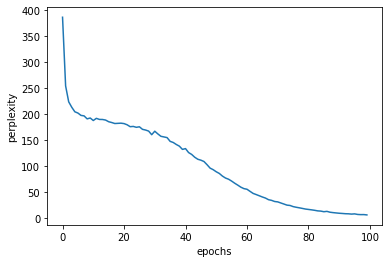

In [121]:
### 퍼플렉서티 그래프
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list)
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

In [122]:
from common.trainer import RnnlmTrainer

In [123]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]
ts = corpus[1:]

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 418.85
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 385.04
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 273.95
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 223.48
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 211.91
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.71
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 202.69
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.72
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 196.02
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.13
| 에폭 11 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 193.53
| 에폭 12 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.90
| 에폭 13 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 193.01
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.66
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.43
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.77
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.77
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.99
| 에폭 19 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 180.24
| 에폭 20 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 181.64
| 에폭 21 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 177.45
| 에폭 22 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 176.

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49436 missing from c

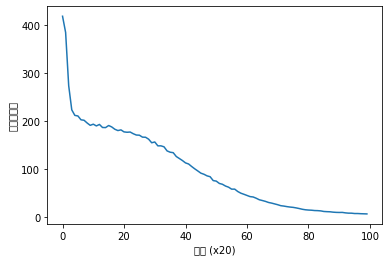

In [125]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()